In [383]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import umap
from collections import Counter
import re
from tqdm import tqdm
import datetime

In [250]:
from numpy import dtype

# Dataset capturado do desafio https://www.kaggle.com/c/titanic/data
df = pd.read_csv('../data/titanic/train.csv')
df_test = pd.read_csv('../data/titanic/test.csv')

y = df.Survived.copy()
X = df.drop('Survived',axis=1).copy()
X_test = df_test.copy()
X.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [411]:
def heuristic_prediction(X,y,X_test,div_fare=1,div_age=1,tresh = 0.9):
    predictions = [] ; print('\nExecutando Heuristica Probabilistica\n')
    Xs = X.join(y).copy()
    Xt = X_test.copy()
    
    Xs['Fare'] = Xs['Fare']//div_fare
    Xs['Age'] = Xs['Age']//div_age
    Xt['Fare'] = Xt['Fare']//div_fare
    Xt['Age'] = Xt['Age']//div_age
    
    for idx, row in Xt.iterrows():
        p1 = Xs['Survived'][Xs['Sex'] == row['Sex']][Xs['Pclass'] == row['Pclass']]
        p2 = Xs['Survived'][Xs['Sex'] == row['Sex']][Xs['Fare'] == row['Fare']]
        p3 = Xs['Survived'][Xs['Sex'] == row['Sex']][Xs['Age'] == row['Age']]
        
        if   len(p1) and sum(p1)/len(p1) > tresh: predictions.append(1) #; print('p1 :', sum(p1)/len(p1))
        elif len(p2) and sum(p2)/len(p2) > tresh: predictions.append(1) #; print('p2 :', sum(p2)/len(p2))
        elif len(p3) and sum(p3)/len(p3) > tresh: predictions.append(1) #; print('p3 :', sum(p3)/len(p3))
        else: predictions.append(0)
    
    return np.array(predictions)

y_pred_test1 = heuristic_prediction(X,y,X_test,tresh=0.9) ; print(y_pred_test1)
print('Percentual de sobreviventes: ', np.sum( y_pred_test1 )/ len( y_pred_test1 ))

y_pred = y_pred_test1
result = X_test[['PassengerId']].copy()
result.loc[:,'Survived'] = y_pred
result.to_csv('submission_heuristic_pred.csv',index=False)
print('Score no Kaggle: 0.7945')


Executando Heuristica Probabilistica

[0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0
 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0
 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0
 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 0 0 0 1 0 0 1 0 0 0]
Percentual de sobreviventes:  0.23923444976076555
Score no Kaggle: 0.7945


In [432]:
def getNaiveSurviveProba(x,X_train,y_train,min_group=5,div_fare=1,div_age=1):
    Xs = X_train.join(y_train).copy()
    xt = x.copy()
    
    if not isinstance(x, pd.Series): raise Exception('x must be a pandas Series of Titanic dataset')
    
    Xs['Fare'] = Xs['Fare']//div_fare
    Xs['Age'] = Xs['Age']//div_age
    Xs['FamilySize'] = Xs.SibSp + Xs.Parch
    Xs['Alone'] = (Xs['FamilySize']<1)//1
    
    if xt.notnull().Fare: xt['Fare'] = xt['Fare']//div_fare
    if xt.notnull().Age:  xt['Age'] = xt['Age']//div_age
    xt['FamilySize'] = xt.SibSp + xt.Parch
    xt['Alone'] = (xt['FamilySize']<1)//1
        
    row = xt
    
    p=0
    p1 = Xs['Survived'][Xs['Sex'] == row['Sex']][Xs['Pclass'] == row['Pclass']]
    p2 = Xs['Survived'][Xs['Sex'] == row['Sex']][Xs['Fare'] == row['Fare']]
    p3 = Xs['Survived'][Xs['Sex'] == row['Sex']][Xs['Age'] == row['Age']]
    p4 = Xs['Survived'][Xs['Sex'] == row['Sex']][Xs['FamilySize'] == row['FamilySize']]
    p5 = Xs['Survived'][Xs['Sex'] == row['Sex']][Xs['Alone'] == row['Alone']]
    p6 = Xs['Survived'][Xs['Sex'] == row['Sex']][Xs['Ticket'] == row['Ticket']]
    p7 = Xs['Survived'][Xs['Sex'] == row['Sex']][Xs['Embarked'] == row['Embarked']]

    if len(p1) and len(p1)>min_group : p = max(p,sum(p1)/len(p1)) #; print('p1 :', sum(p1)/len(p1))
    if len(p2) and len(p2)>min_group : p = max(p,sum(p2)/len(p2)) #; print('p2 :', sum(p2)/len(p2))
    if len(p3) and len(p3)>min_group : p = max(p,sum(p3)/len(p3)) #; print('p3 :', sum(p3)/len(p3))
    if len(p4) and len(p4)>min_group : p = max(p,sum(p4)/len(p4)) #; print('p3 :', sum(p3)/len(p3))
    if len(p5) and len(p5)>min_group : p = max(p,sum(p5)/len(p5)) #; print('p3 :', sum(p3)/len(p3))
    if len(p6) and len(p6)>min_group : p = max(p,sum(p6)/len(p6)) #; print('p3 :', sum(p3)/len(p3))
    if len(p7) and len(p7)>min_group : p = max(p,sum(p7)/len(p7)) #; print('p3 :', sum(p3)/len(p3))
   
    return p

In [433]:
aux = X_test.apply(getNaiveSurviveProba,args=(X,y,3,3,2,),axis=1)
y_pred_test2 = (np.array(aux)>0.9)//1
print('Percentual de sobreviventes: ', np.sum( y_pred_test2 )/ len( y_pred_test2 ))
y_pred_test2 - y_pred

Percentual de sobreviventes:  0.20095693779904306


array([ 0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

<AxesSubplot:>

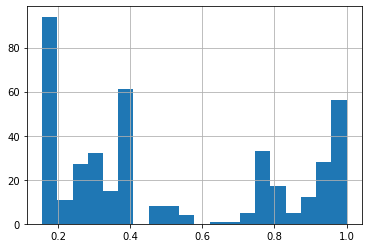

In [436]:
aux.hist(bins=20)

In [413]:
y_pred_test2 = (np.array(aux)>0.9)//1
print('Percentual de sobreviventes: ', np.sum( y_pred_test2 )/ len( y_pred_test2 ))

y_pred2 = y_pred_test2
result = X_test[['PassengerId']].copy()
result.loc[:,'Survived'] = y_pred2
result.to_csv('submission_heuristic_pred'+datetime.datetime.now().strftime('%Y%m%d%H%M%S')+'.csv',index=False)
print('Score no Kaggle: 0.78468')

Percentual de sobreviventes:  0.24641148325358853
Score no Kaggle: 0.78468


In [437]:
from tpot import TPOTClassifier

D:\ProgramData\Miniconda3\envs\ppcomp\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [438]:
pipeline_optimizer = TPOTClassifier(generations=5, population_size=20, cv=5,
                                    random_state=42, verbosity=2)
pipeline_optimizer.fit(X, y)

Imputing missing values in feature set


ValueError: Cannot use median strategy with non-numeric data:
could not convert string to float: 'Braund, Mr. Owen Harris'